## Plot setting {visibility="hidden"}

In [1]:
# Run this first!

import matplotlib as mpl
import seaborn as sns
import numpy as np
import seaborn as sns
from scipy import stats
import pyjags
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display, clear_output

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams["figure.facecolor"] =  (0.0, 0.0, 0.0, 0.0)
mpl.rcParams["axes.facecolor"] =  (0.0, 0.0, 0.0, 0.0)

seaborn_colors = sns.color_palette()

## The modeling workflow {.scrollable}

Recreated from @wilsonTenSimpleRules2019


```{mermaid}
%%| echo: false
%%| fig-width: 10

flowchart TB

  subgraph Panel1 [<font size=4>Planning stage]
    direction LR
    A1[<font size=4>Design experiment]
    A2[<font size=4>Build models]
    A1 <--> A2
  end

  subgraph Panel2 [<font size=4>Model evaluation]
    direction TB
    B1[<font size=4>Simulate model and experiment]
    B2[<font size=4>Parameter recovery?]
    B3[<font size=4>Model recovery?]
    B1 --> B2
    B1 --> B3
  end

  subgraph Panel3 [<font size=4>Analysis]
    direction TB
    C1[<font size=4>Fit real data]
    C2[<font size=4>Parameter fits]
    C3[<font size=4>Model comparison]
    C4[<font size=4>Validate the model]
    C1 --> C2
    C1 --> C3
    C2 --> C4
    C3 --> C4
  end

  subgraph Panel4 [<font size=4>Final]
    direction LR
    D1[<font size=4>Latent variable analysis]
    D2[<font size=4>Report Results]
  end
  b1{{<font size=4>Can model and experiment\nanswer question in theory?}}
  b2{{<font size=4>Can model account for the  data?}}

  back1[Back to top]
  Panel1 --> Panel2
  Panel2 --> b1
  b1 -- yes --> Panel3
  Panel3 --> b2 -- yes --> Panel4
  b1 -.->|no| back1
  b2 -.->|no| back1
```


## The lecture
:::: {.columns}

::: {.column width="49%"}


### Parameter Recovery

::: {.nonincremental}

* Can your model provide meaningful parameter estimates in a best case scenario?
:::
:::

::: {.column width="49%"}

::: {.fragment .semi-fade-out }
### Model recovery

::: {.nonincremental}
* How unique is the data predicted by your models?
* Do other models explain the data just as well?
:::
:::
:::
::::

# Parameter Recovery

## The setting

* In our next study we want to investigate reward learning.
* For this we use a two armed bandit tasked.
* Participants decide between slot machines on a screen (🎰A, 🎰B).
    * 🎰A - gives a reward of 1 kr 80 % of the time
    * 🎰B - gives a reward of 3 kr 20 % of the time

![ ](images/Slot_machine.jpg){height="250px"}

::: aside
https://commons.wikimedia.org/wiki/File:Slot_machine.jpg, cc-by-sa-2.0
:::

## The question


* Our hypothesis is that participants will prefer 🎰A, as it is advantageous in the long run.
  * So the question is: How often do participants select machine 🎰A?
  * Our observation: The number of times 🎰A is preferred over 🎰B
  * &nbsp;

![ ](images/Slot_machine.jpg){height="250px"}

::: aside
https://commons.wikimedia.org/wiki/File:Slot_machine.jpg, cc-by-sa-2.0
:::

## The model


:::: {.columns}
::: {.column width="49%"}

As you have seen, we can use a rate model to describe the process.

* $\theta$ - proportion of selected 🎰A
* $n$ - the number of trials
* $k$ - the outcome (i.e., counts of 🎰A)

:::
::: {.column width="49%"}


```{dot}
//| echo: false
//| fig-width: 3

// Figure of the simple rate model
digraph fig1 {
bgcolor="transparent"
rankdir = TB; //order things from left to right
θ [shape=circle];
n [shape=square, style=filled];
k [shape=square, style=filled]
θ -> k
n -> k
}
```


:::
::::

## Ready to go?

Not so fast:

* How well does the model actually work?
  * Can we trust the estimated parameters?
  * Do we have the correct priors?
* Does our experiment work?
  * Do we have enough trials to get accurate parameter estimates?
  * Should we change the experimental design?


## Generating data

:::: {.columns}
::: {.column width="49%"}
::: {.fragment}

* In our setting, we can generate data by sampling from a binomial distribution:

* $k \sim \text{Binomial}(n, \theta)$

:::
:::
::: {.column width="49%"}
::: {.fragment}

We could also sample using the JAGS model


```{dot}
//| echo: false
//| fig-width: 3
digraph fig1 {
bgcolor="transparent"
rankdir = TB; //order things from left to right

θ [shape=circle];
n [shape=square, style=filled];
k [shape=square, style=filled]
θ -> k
n -> k
}
```


:::
:::
::::

* Sometimes the way we generate data is different from the model we use for inference

## Recovering parameters
:::: {.columns}
::: {.column width="49%"}

We use our model to generate data.

* Let's say our experiment has $n = 25$ trials.
* For example we test a $\theta = 0.7$.
* We generate $50$ synthetic datasets.
* Finally, we see how well we can recover $\theta$.

:::
::: {.column width="49%"}


```{dot}
//| echo: false
//| fig-width: 3
digraph fig1 {
bgcolor="transparent"
rankdir = TB; //order things from left to right

θ [label="θ = 0.7", shape=circle, syle=filled];
n [label="n = 25",shape=square, style=filled];
k [shape=square, style=filled]
θ -> k
n -> k
}
```


:::
::::


## Let's do it
:::: {.columns}
::: {.column width="49%"}
::: {.fragment}


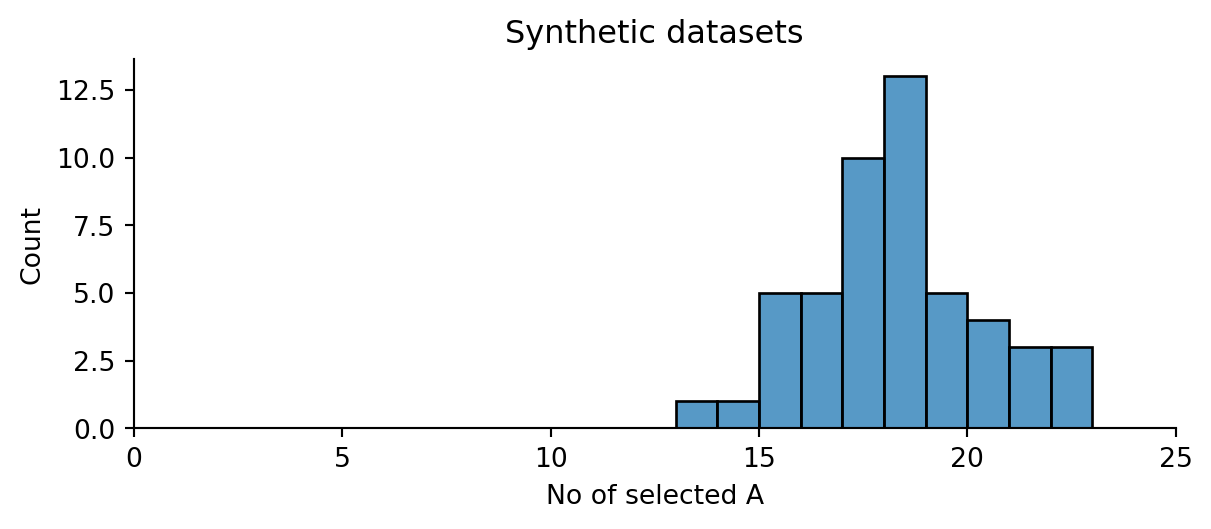

In [2]:
# Let's generate data:
rate_model = '''
model {
   # Prior Distribution for Rate Theta
   theta ~ dbeta(1.0, 1.0)
   # Observed Counts
   k ~ dbin(theta, n)
}'''

theta = 0.7
n_trials = 25
n_datasets = 50
# We can use the same function as before, but use n_datsets for the trial size
example_datasets_25 = stats.binom(n_trials, theta).rvs(n_datasets)

fig, axes = plt.subplots(1, 1, figsize=(7, 2.5))
sns.histplot(x=example_datasets_25)
axes.set(title="Synthetic datasets", xlabel="No of selected A", xlim=[0, 25]);

:::
:::
::: {.column width="49%"}
::: {.fragment}


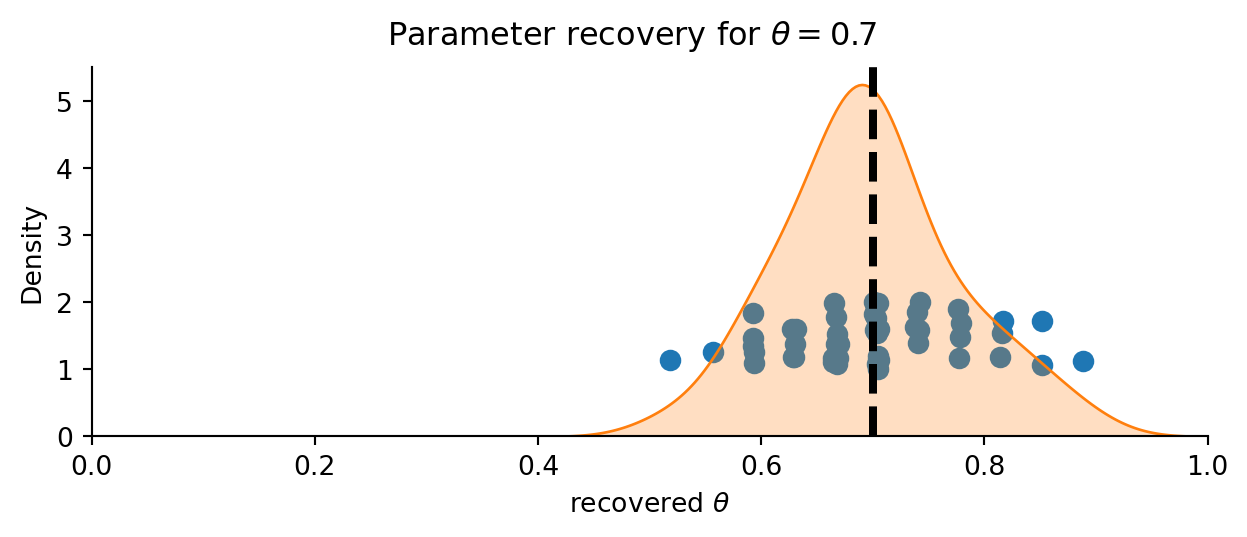

In [3]:
mean_estimates_25 = np.zeros(n_datasets)

for n, ed in enumerate(example_datasets_25):
    # Set data to new dataset
    jags_data_25 = {'k': ed, "n": n_trials}
    # Recover parameter
    jags_model_tmp  = pyjags.Model(code=rate_model, data=jags_data_25,
                                  chains=2, adapt=500, progress_bar=False)
    samples = jags_model_tmp.sample(2500, vars=['theta']);
    # Store mean of traces - these are the recovered parameters
    mean_estimates_25[n] = np.mean(samples['theta'].ravel())

# Plotting:
fig, axes = plt.subplots(1, 1, figsize=(7.5, 2.5))
jitter_25 = 1 + np.zeros_like(mean_estimates_25) + np.random.rand(n_datasets)
axes.scatter(mean_estimates_25, jitter_25 , s=50)
sns.kdeplot(mean_estimates_25, ax=axes, fill=True)
axes.axvline(theta, color='black', linewidth=3, linestyle='--')
axes.set(xlim=[0, 1], xlabel=r"recovered $\theta$");
plt.suptitle(r"Parameter recovery for $\theta=0.7$");

:::
:::
::::

## Adapt the experiment

Do more trials help?

::: {.fragment}


/var/folders/dl/960vgd8949vgx1t06vcllfr00000gn/T/ipykernel_77967/1824580276.py:31: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  axes[1].scatter(mean_estimates_75, jitter_75, s=50, c=seaborn_colors[1] + (0.5,))


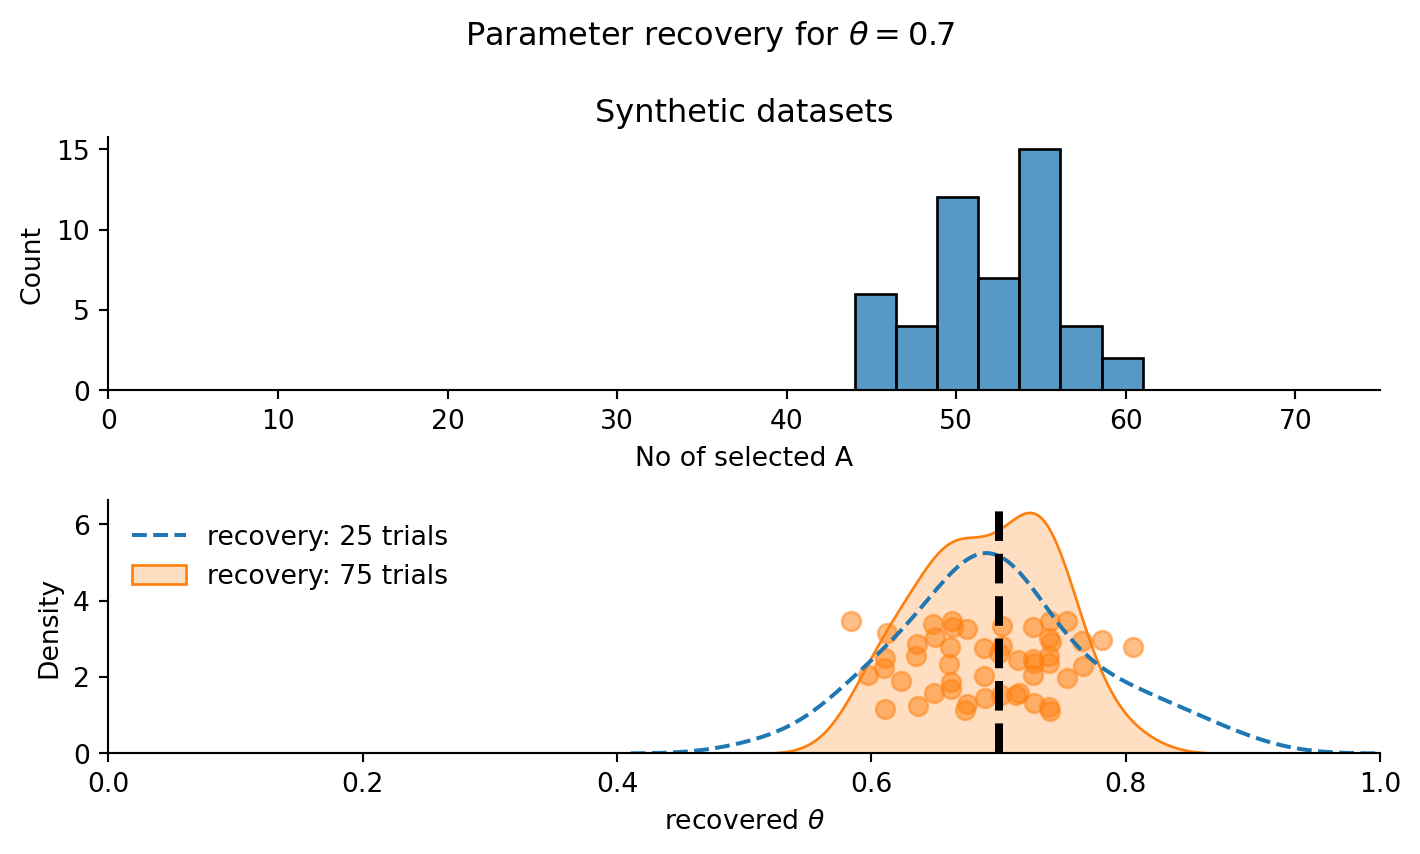

In [4]:
theta = 0.7
n_trials = 75
n_datasets = 50
# We can use the same function as before, but use n_datsets for the trial size
example_datasets_75 = stats.binom(n_trials, theta).rvs(n_datasets)

mean_estimates_75 = np.zeros(n_datasets)

for n, ed in enumerate(example_datasets_75):

    # Set data to new dataset
    jags_data_75 = {'k': ed, "n": n_trials}
    # Recover parameter
    jags_model_75  = pyjags.Model(code=rate_model, data=jags_data_75, chains=2,
                  adapt=500, progress_bar=False)
    samples = jags_model_75.sample(2500, vars=['theta']);

    # Store mean of traces - these are the recovered parameters
    mean_estimates_75[n] = np.mean(samples['theta'].ravel())

fig, axes = plt.subplots(2, 1, figsize=(7.5, 4.5))

sns.histplot(x=example_datasets_75, ax=axes[0])
axes[0].set(title="Synthetic datasets", xlabel="No of selected A", xlim=[0, n_trials]);

sns.kdeplot(mean_estimates_25, ax=axes[1], fill=False, linestyle='--',
            color=seaborn_colors[0], label="recovery: 25 trials")
sns.kdeplot(mean_estimates_75, ax=axes[1], fill=True, color=seaborn_colors[1],
            label="recovery: 75 trials")
jitter_75 = 1 + np.zeros_like(mean_estimates_75) + np.random.rand(n_datasets) * 2.5
axes[1].scatter(mean_estimates_75, jitter_75, s=50, c=seaborn_colors[1] + (0.5,))
axes[1].axvline(theta, color='black', linewidth=3, linestyle='--')
axes[1].set(xlim=[0, 1], xlabel=r"recovered $\theta$");
plt.suptitle(r"Parameter recovery for $\theta=0.7$");
axes[1].legend(fancybox=False, framealpha=0.0)
plt.tight_layout()

:::

## Play around

Code is in the jupyter notebook


In [5]:
#| echo: false

def run_simulation(theta, n_trials, jags_model, n_experiments=50):
    """
    This function is also used for simulating data in the functions below.
    """

    mean_estimates = np.zeros(n_experiments)
    datasets = np.zeros(n_experiments)
    for c in range(n_experiments):
        counts = stats.binom(n_trials, theta).rvs()
        data = {'k': counts, 'n': n_trials}

        model = pyjags.Model(code=jags_model, data=data, chains=2, adapt=500, progress_bar=False)
        samples = model.sample(1000, vars=['theta'])

        # Get mean estimates per chain
        mean_estimates[c] = np.mean(samples['theta'].ravel())
        datasets[c] = counts

    return mean_estimates, theta, datasets

# GUI widgets
theta_slider = widgets.FloatSlider(value=0.5, min=0.00, max=1.0, step=0.1,
                                  description='Theta:')
n_slider = widgets.IntSlider(value=25, min=5, max=100, step=10,
                            description='n_trials:')


# Update function
def update_plot(theta, n_trials):
    mean_estimates, true_theta, datasets = run_simulation(theta, n_trials, jags_model=rate_model)

    fig, axes = plt.subplots(2, 1, figsize=(7.5, 4.5))
    sns.histplot(x=datasets, ax=axes[0])
    axes[0].set(title="Synthetic datasets", xlabel="No of selected A", xlim=[0, 100]);
    sns.kdeplot(mean_estimates, ax=axes[1], fill=True)
    jitter_tmp = 1 + np.zeros_like(mean_estimates) + np.random.rand(len(mean_estimates)) * 2.5
    axes[1].scatter(mean_estimates, jitter_tmp, s=50)
    axes[1].axvline(theta, color='black', linewidth=3, linestyle='--')
    axes[1].set(xlim=[0, 1], xlabel=r"recovered $\theta$");
    plt.suptitle(r"Parameter recovery for $\theta$");
    plt.tight_layout()

# Display interactive widget
interactive_plot = widgets.interactive(update_plot, theta=theta_slider,
                                       n_trials=n_slider)
display(interactive_plot)

interactive(children=(FloatSlider(value=0.5, description='Theta:', max=1.0), IntSlider(value=25, description='…

## A full parameter recovery study

* Often we simulate data over larger parameter spaces.
* We simulate $\theta$ for the values $\in[0, 0.1, \dots, 0.9, 1.0]$,
assuming $n=50$ trials, and simulating 50 datasets for each point.

::: {.fragment}


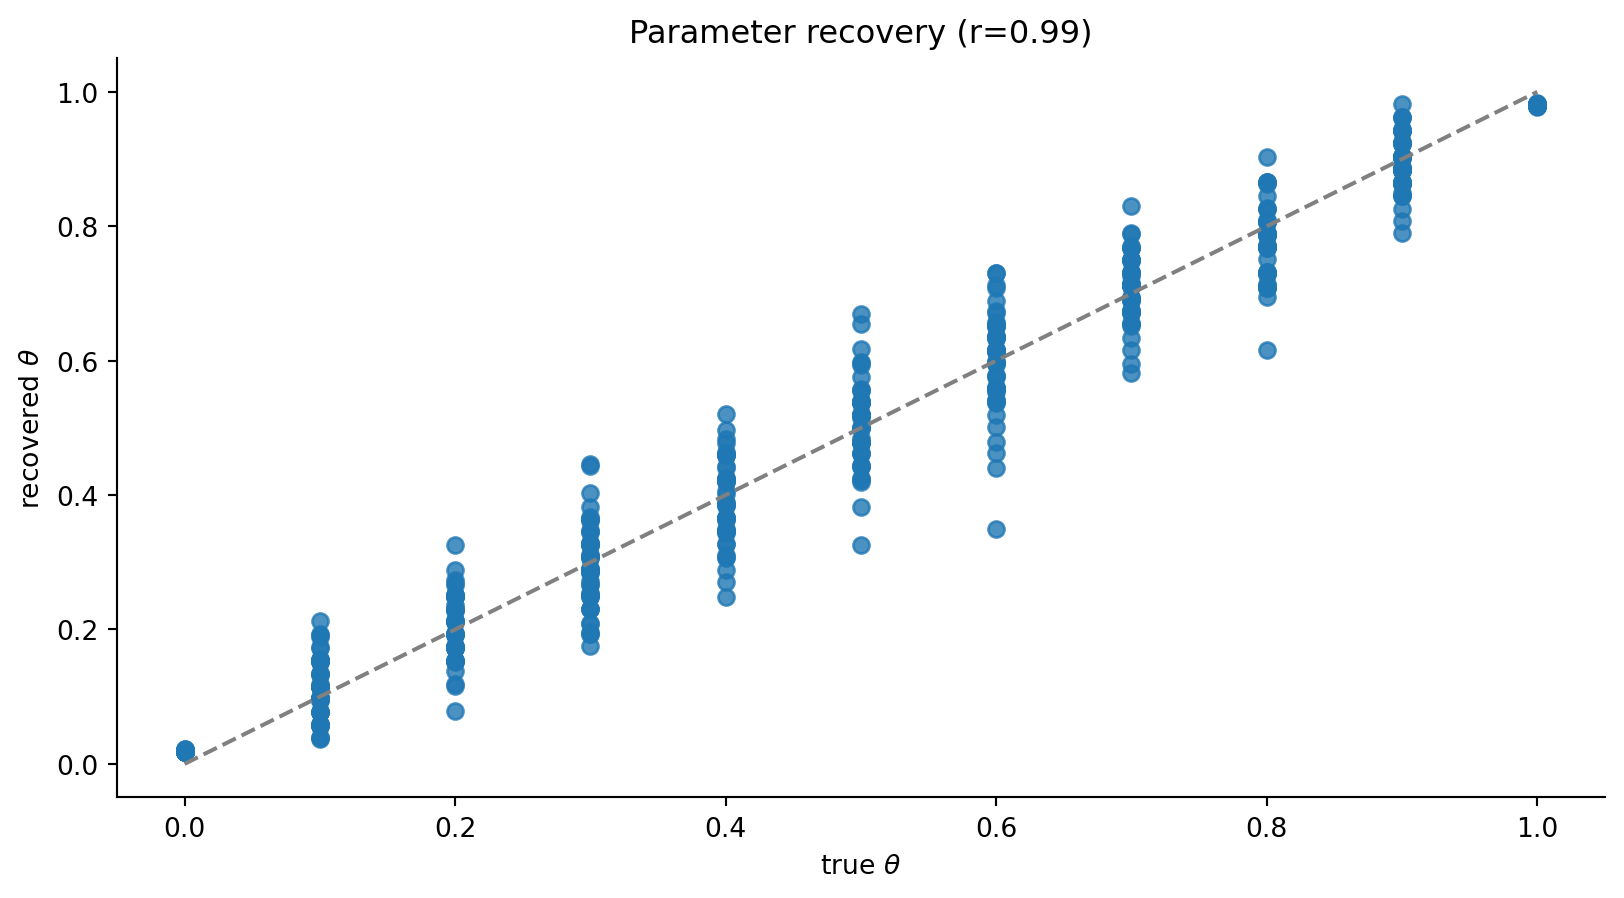

In [6]:
# Sampling function

theta_true = np.linspace(0, 1, 11)

theta_pred = []
theta_trues = []

for tt in theta_true:
    mean_estimates, _, _ = run_simulation(tt, n_trials=50, jags_model=rate_model)
    theta_pred.append(mean_estimates)

theta_pred = np.array(theta_pred).ravel()
theta_true = np.repeat(theta_true, 50)

fig, axes = plt.subplots(1, 1)

sns.regplot(y=theta_pred, x=theta_true, ax=axes, fit_reg=False)
axes.plot([0, 1], [0, 1], linestyle='--', color='gray')

axes.set(title=f"Parameter recovery (r={stats.pearsonr(theta_pred, theta_true)[0]:4.2f})",
ylabel=r'recovered $\theta$', xlabel=r'true $\theta$', xlim=[-0.05,1.05], ylim=[-0.05,1.05]);

:::

## What can go wrong

The same simulation, but something went, wrong, any ideas?

:::: {.columns}
::: {.column width="50%"}


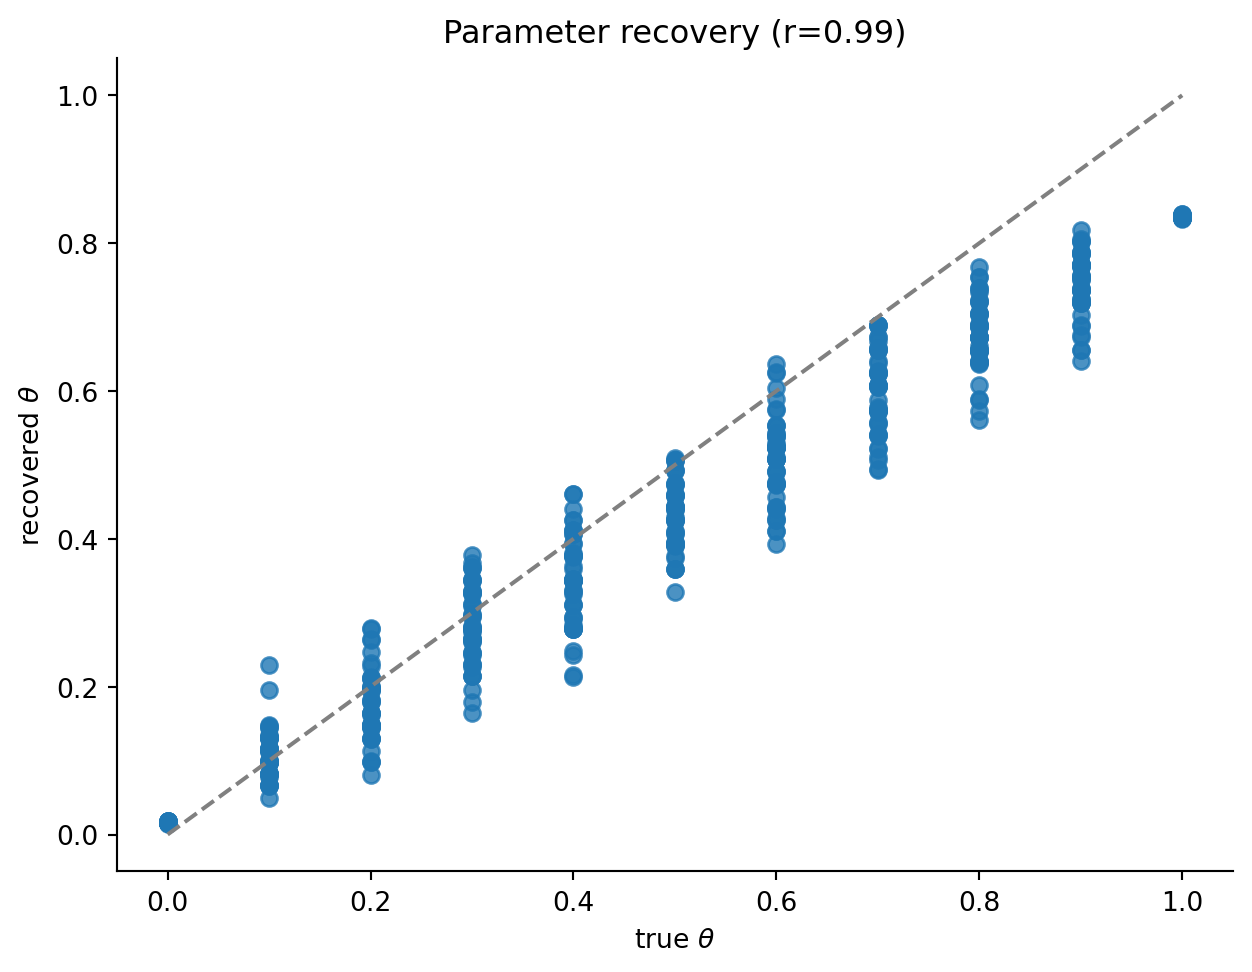

In [7]:
#| echo: false
rate_model_typo = '''
model {
   # Prior Distribution for Rate Theta
   theta ~ dbeta(1.0, 10.0)
   # Observed Counts
   k ~ dbin(theta, n)
}'''

theta_true = np.linspace(0, 1, 11)

theta_pred = []
theta_trues = []

for tt in theta_true:
    mean_estimates, _, _ = run_simulation(tt, n_trials=50, jags_model=rate_model_typo)
    theta_pred.append(mean_estimates)

theta_pred = np.array(theta_pred).ravel()
theta_true = np.repeat(theta_true, 50)

fig, axes = plt.subplots(1, 1, figsize=(7.5, 5.5))

sns.regplot(y=theta_pred, x=theta_true, ax=axes, fit_reg=False)
axes.plot([0, 1], [0, 1], linestyle='--', color='gray')

axes.set(title=f"Parameter recovery (r={stats.pearsonr(theta_pred, theta_true)[0]:4.2f})",
ylabel=r'recovered $\theta$', xlabel=r'true $\theta$', xlim=[-0.05,1.05], ylim=[-0.05,1.05]);

:::

::: {.column width="50%"}
::: {.fragment}


In [8]:
print(rate_model_typo)


model {
   # Prior Distribution for Rate Theta
   theta ~ dbeta(1.0, 10.0)
   # Observed Counts
   k ~ dbin(theta, n)
}


:::
:::
::::
## What to look out for

:::: {.columns}

::: {.column width="50%"}
![Bias](images/High_precision_Low_accuracy.svg.png)
:::

::: {.column width="50%"}
![Reliability](images/High_accuracy_Low_precision.svg.png)
:::

::::

::: aside
https://en.wikipedia.org/wiki/Accuracy_and_precision
:::


## Always plot your data


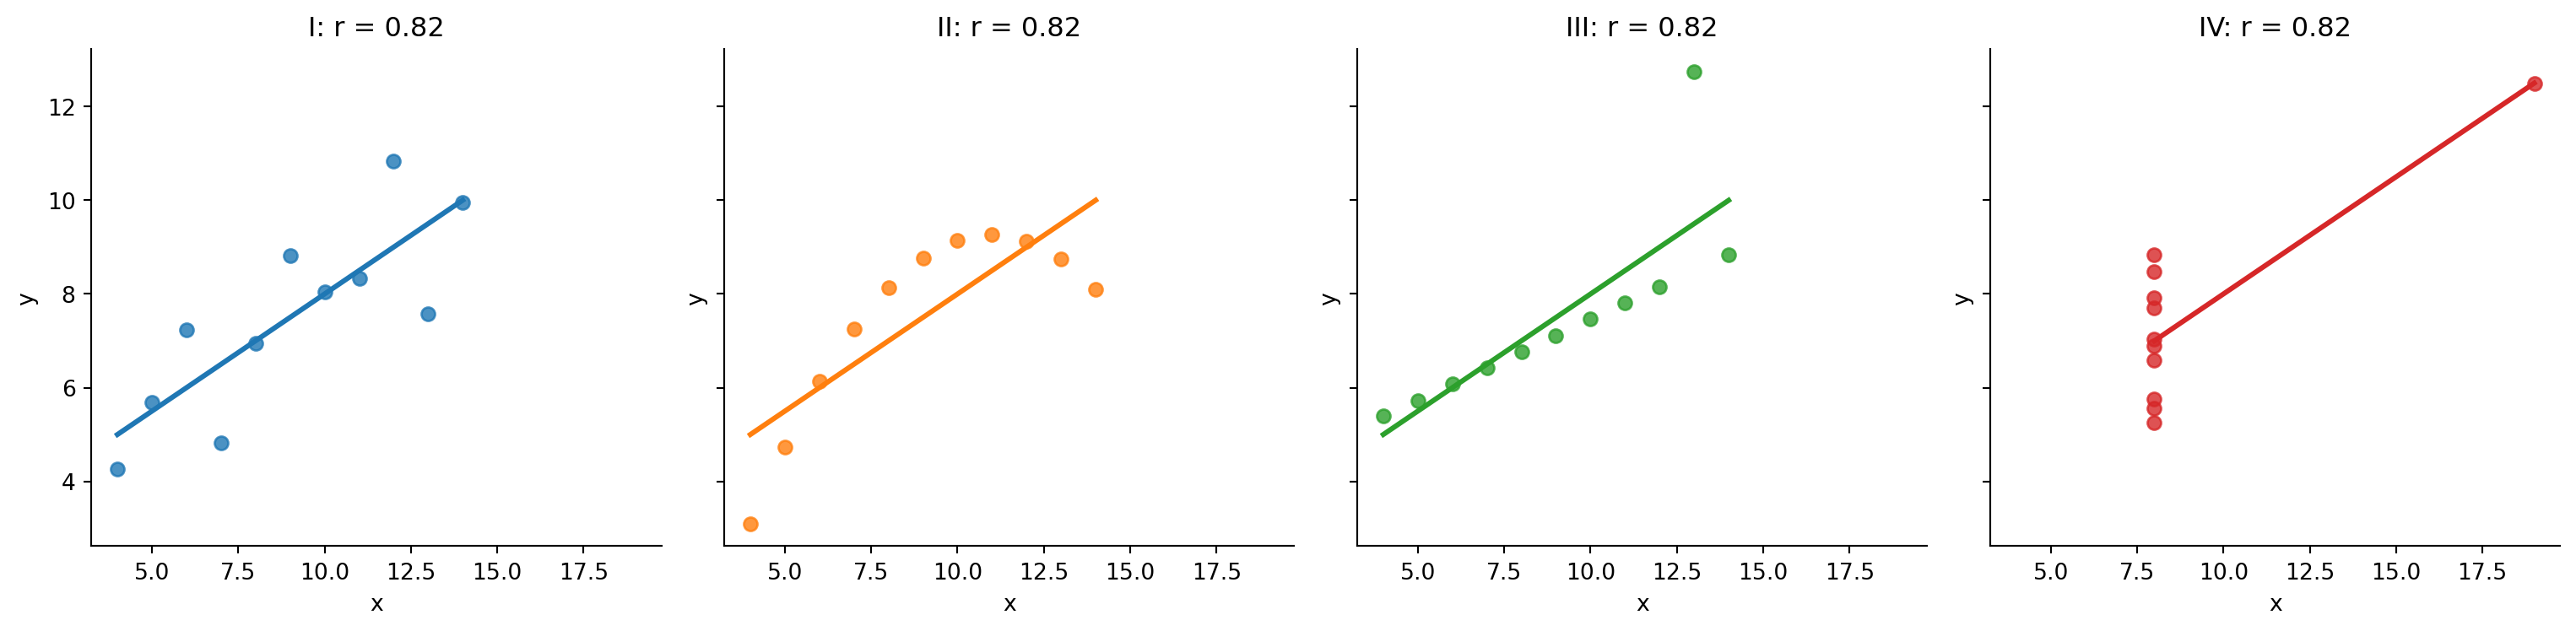

In [9]:
#| echo: false
# Load the example dataset for Anscombe's quartet
df = sns.load_dataset("anscombe")

fig, axes = plt.subplots(1, 4, figsize=(16, 4), sharex=True, sharey=True)
axes = axes.flatten()

for n, (ds, col) in enumerate(zip(df.dataset.unique(), seaborn_colors)):
    tmp_data = df.query("dataset == @ds").copy()
    sns.regplot(data=tmp_data, x='x', y='y', ci=None, ax=axes[n], color=col)
    axes[n].set(title=f"{ds}: r = {stats.pearsonr(tmp_data['x'], tmp_data['y'])[0]:4.2f}")

plt.tight_layout()

<span style="opacity: 0.5;">Anscombe's quartet [@anscombeGraphsStatisticalAnalysis1973] -  also check out the datasaurus [@matejkaSameStatsDifferent2017].</span>

# Intermediate Summary

## Parameter recovery

### How?

* Generate synthetic data, using your model.
* Use your model to infer the parameters.
* Knowing the ground truth: Assess uncertainty and bias.
  * Plot correlation between parameters
  * Plot correlation between true and recovered parameters

### Why?

* Checks if your model theoretically can get good results in a best case sceneario.
* Checks if your model has any bugs in it.
* Checks if your experimental design is appropriate.

## Some guidelines

For example see @heathcoteIntroductionGoodPractices2015 and @wilsonTenSimpleRules2019

* Make your simulation as close as possible to the real study:
  * Same sample size
  * Same number of trials
* Use the model recovery process to optimize your experimental design:
  * Investigate how many trials are needed for reliability.
  * Use it for power analysis.
* Use realistic parameters from the literature or pilot studies.
* Check if parameter boundaries are correctly defined (e.g., priors)
* If you do not have any prior information: Sample the whole parameter space to test your assumptions.


## The modeling workflow {.scrollable}

Recreated from @wilsonTenSimpleRules2019


```{mermaid}
%%| echo: false
%%| fig-width: 10

flowchart TB

  subgraph Panel1 [<font size=4>Planning stage]
    direction LR
    A1[<font size=4>Design experiment]
    A2[<font size=4>Build models]
    A1 <--> A2
  end

  subgraph Panel2 [<font size=4>Model evaluation]
    direction TB
    B1[<font size=4>Simulate model and experiment]
    B2[<font size=4>Parameter recovery?]
    B3[<font size=4>Model recovery?]
    B1 --> B2
    B1 --> B3
  end

  subgraph Panel3 [<font size=4>Analysis]
    direction TB
    C1[<font size=4>Fit real data]
    C2[<font size=4>Parameter fits]
    C3[<font size=4>Model comparison]
    C4[<font size=4>Validate the model]
    C1 --> C2
    C1 --> C3
    C2 --> C4
    C3 --> C4
  end

  subgraph Panel4 [<font size=4>Final]
    direction LR
    D1[<font size=4>Latent variable analysis]
    D2[<font size=4>Report Results]
  end
  b1{{<font size=4>Can model and experiment\nanswer question in theory?}}
  b2{{<font size=4>Can model account for the  data?}}

  back1[Back to top]
  Panel1 --> Panel2
  Panel2 --> b1
  b1 -- yes --> Panel3
  Panel3 --> b2 -- yes --> Panel4
  b1 -.->|no| back1
  b2 -.->|no| back1
```



## The lecture
:::: {.columns}
::: {.column width="49%"}
::: {.fragment .semi-fade-out}

### Parameter Recovery

::: {.nonincremental}
* Can your model provide meaningful parameter estimates in a best case scenario?
:::
:::
:::
::: {.column width="49%"}

### Model recovery
::: {.nonincremental}

* How unique is the data predicted by your models?
* Do other models explain the data just as well?
:::

:::
::::


## We take our experiment to the RM

* But how do you test the results?
  * Run the model for each participant, and do a t-test against 0.5.
* What is a better test?
  * Machine 🎰A is selected at random ($\theta=0.5$).
  * We fit this all into a latent mixture model.

## Defining the model

:::: {.columns}
::: {.column width="49%"}
::: {.fragment}


In [10]:
model_comparison = """
model {
  z ~ dcat(pi[1:2])
  pi[1] <- 0.5
  pi[2] <- 0.5

  theta[1] <- 0.5
  theta[2] ~ dbeta(1, 1)

  k ~ dbin(theta[z], n)
}
"""
print(model_comparison)


model {
  z ~ dcat(pi[1:2])
  pi[1] <- 0.5
  pi[2] <- 0.5

  theta[1] <- 0.5
  theta[2] ~ dbeta(1, 1)

  k ~ dbin(theta[z], n)
}



:::
:::
::: {.column width="49%"}
::: {.fragment}


```{dot}
//| echo: false
//| fig-width: 3
digraph fig1 {
bgcolor="transparent"
rankdir = TB; //order things from left to right

free [label="θ", shape=circle];
fix [label="0.5", shape=circle, style=filled];
switch [label="θ", shape=circle, peripheries=2]
n [label="n",shape=square, style=filled];
k [shape=square, style=filled]
z [shape=square]

free -> switch
fix -> switch
z -> switch

switch -> k
n -> k
}
```


:::
:::
::::

## Generate data

* We generate synthetic data for each of our models in the comparison.
* Model 1: 200 datasets, with $\theta=0.5$.
* Model 2: 200 datasets, sampling ($\theta \sim \mathcal{U}[0, 1]$).
* We also assume $n=75$ trials.

::: {.fragment}


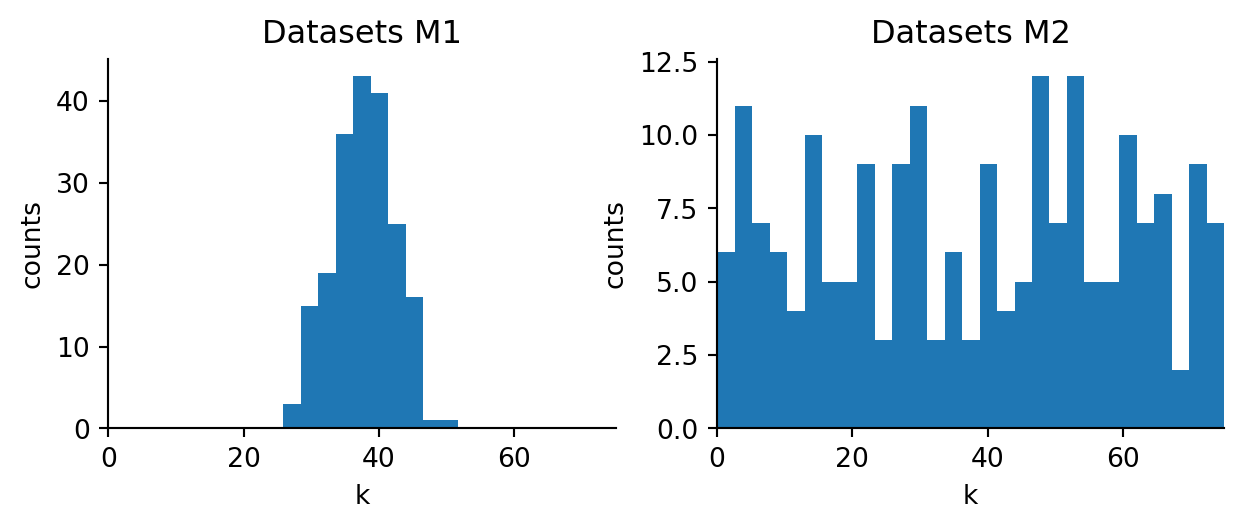

In [11]:
# We could use the sampling function of the jags model but
# sometimes it's easier to use the generative process:
n_trials = 75
n_datasets = 200

theta_1 = 0.5
k_model1 = stats.binom(n_trials, theta_1).rvs(n_datasets)

theta_2 = np.sort(stats.uniform(0, 1).rvs(n_datasets))
k_model2 = np.array([stats.binom(n_trials, t2).rvs() for t2 in theta_2])

confusion_matrix = np.zeros((2, 2))
evidence_m1 = np.zeros((2, n_datasets))
winning_m = np.zeros((2, n_datasets))

for n_m, ks in enumerate([k_model1, k_model2]):
    for n_k, ktmp in enumerate(ks):
        jags_model = pyjags.Model(code=model_comparison, chains=2,
                                adapt=1000, progress_bar=False,
                                data={"k": ktmp, "n": 75})

        samps = jags_model.sample(2500)
        ev_model_1 = np.mean(samps['z'].ravel() == 1)
        ev_model_2 = np.mean(samps['z'].ravel() == 2)
        winning_model = np.argmax([ev_model_1, ev_model_2])
        winning_m[n_m, n_k] = winning_model
        evidence_m1[n_m, n_k] = ev_model_1
        confusion_matrix[n_m, winning_model] += 1

fig, axes = plt.subplots(1, 2, figsize=(7.5, 2.5))
axes[0].hist(k_model1, bins=np.linspace(0, n_trials, 30))
axes[1].hist(k_model2, bins=np.linspace(0, n_trials, 30))
axes[0].set(xlim=[0, n_trials], xlabel="k", ylabel="counts",
            title="Datasets M1")
axes[1].set(xlim=[0, n_trials], xlabel="k", ylabel="counts",
            title="Datasets M2");

:::

## We now infer the model for each of the two separate datasets

* We simply select models by the higher posterior probability
* This means we need to run a bunch of simulations and inference runs.
* Then we count
  * Dataset 1: How often does model 1 or model 2 win.
  * Dataset 2: How often does model 1 or model 2 win.


## Diagnosing Model recovery

:::: {.columns}

::: {.column width="49%"}

::: {.fragment}


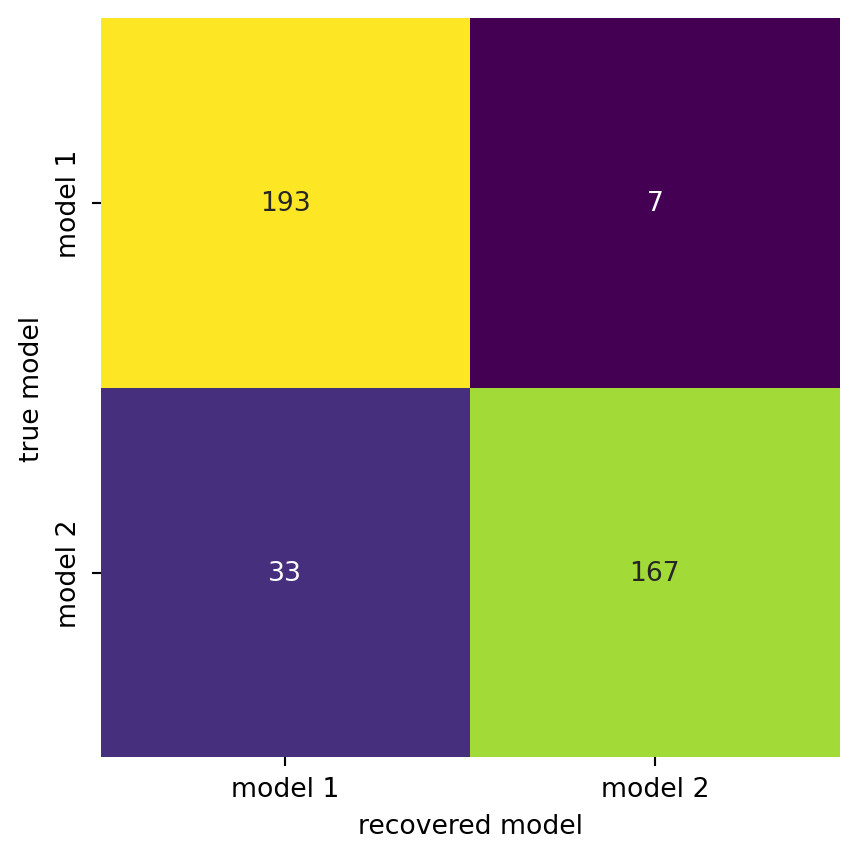

In [12]:
#| echo: false
# Plotting confusion matrix
fig, axes = plt.subplots(1, 1)
sns.heatmap(confusion_matrix, square=True, annot=True, cmap='viridis', ax=axes, xticklabels=['model 1', 'model 2'], yticklabels=['model 1', 'model 2'], fmt=".3g", cbar=False)
axes.set(ylabel='true model', xlabel='recovered model');

:::
:::
::: {.column width="49%"}
::: {.fragment}


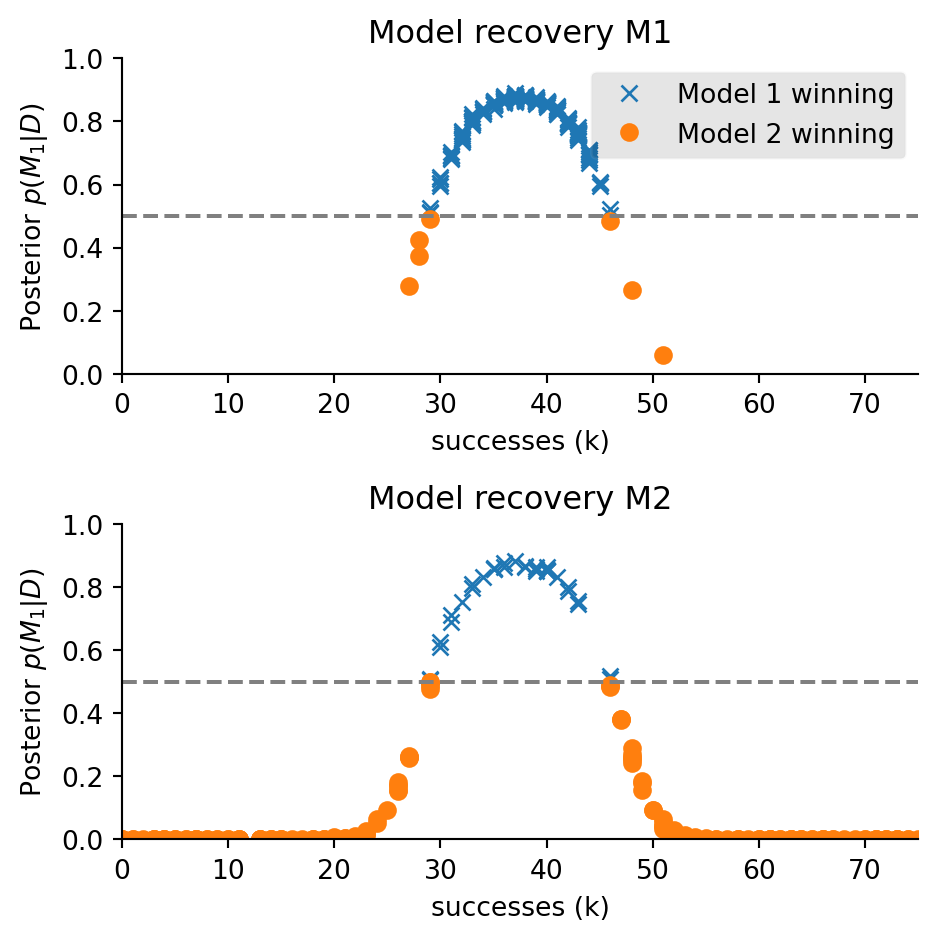

In [13]:
#| echo: false
# Plotting confusion matrix

fig, axes = plt.subplots(2, 1, figsize=(5, 5))

axes[0].plot(k_model1[evidence_m1[0, :] > 0.5],
             evidence_m1[0, :][evidence_m1[0, :] > 0.5], 'x')
axes[0].plot(k_model1[evidence_m1[0, :] < 0.5],
             evidence_m1[0, :][evidence_m1[0, :] < 0.5], 'o')

axes[1].plot(k_model2[evidence_m1[1, :] > 0.5],
             evidence_m1[1, :][evidence_m1[1, :] > 0.5], 'x')
axes[1].plot(k_model2[evidence_m1[1, :] < 0.5],
             evidence_m1[1, :][evidence_m1[1, :] < 0.5], 'o')
axes[0].legend(["Model 1 winning", "Model 2 winning"], framealpha=0.1,
loc='upper right')
axes[0].axhline(0.5, linestyle='--', color='gray')
axes[1].axhline(0.5, linestyle='--', color='gray')
axes[0].set(ylim=[0, 1], xlim=[0, 75], xlabel="successes (k)",  ylabel=r"Posterior $p(M_1|D)$", title="Model recovery M1")
axes[1].set(ylim=[0, 1], xlim=[0, 75],xlabel="successes (k)",  ylabel=r"Posterior $p(M_1|D)$", title="Model recovery M2");
plt.tight_layout()

:::
:::
::::


## Model recovery

### How?

* Generate synthetic data, using the different models.
* Fit each model to each datasets
* Knowing the ground truth: Can you recover the underlying model?
  * Plot the confusion matrix
  * Investigate where confusion happens.

### Why?

* Checks if your models can be recovered in an ideal sceneario.
* Checks if your models can actually answer your research questions.
* Checks if your experimental design is appropriate.

## More

* Parameters matter - be carefuly how you simulate data!
* Try to be as close as possible to your study:
    * Sample size
    * Number of trials
    * Parameters / priors
* If you do not know:
    * Simulate, simulate, simulate (sample parameters from wide ranges)

## The great thing:

Everything I talked about works just as well for frequentist models :)



# Stories from the lab

## The Copenhagen experiment [@mederErgodicitybreakingRevealsTime2021]

![](images/model_space.png){width=700}

::: aside
@mederErgodicitybreakingRevealsTime2021, CC-BY 4.0
:::

## Parameter recovery

Simulated data:

* Generate a grid of utility parameters ($\eta$)
  * $\eta \in [-0.5, 0.0, 0.5, 1.0, 1.5]$
  * $\eta_{\text{sim}} \sim \mathcal{N}(\eta_i, 0.1)$
  * For each combination there were 20 subjects
* Simulate $\beta$:
  * $\beta$ has been used in a linear relationship to $\eta$

## Parameter recovery

![](images/parameter_recovery.png){width=700}

::: aside
@mederErgodicitybreakingRevealsTime2021, CC-BY 4.0
:::


## Model recovery

:::: {.columns}
::: {.column width="60%"}

Simulate data:

* Generating 9 prospect theory agents ($\lambda \in [1, 2, 3]$, $\alpha \in [0.6, 0.8, 0.9]$)
* Generating 9 iso-elastic agents ($\eta \in [-0.5, -0.2, 0.0, 0.2, 0.5, 0.8, 1.0, 1.2, 1.5]$)
* Generating 9 time-optimal agents
* Using a fixed $\beta_{\text{add}} = \exp(-1)$, $\beta_{\text{mult}}=\exp(5)$

:::

::: {.column width="40%"}
::: {.fragment}
![](images/model_recovery.png){width=300}
:::
:::
::::

::: aside
@mederErgodicitybreakingRevealsTime2021, CC-BY 4.0
:::

## The modeling workflow {.scrollable}

Recreated from @wilsonTenSimpleRules2019


```{mermaid}
%%| echo: false
%%| fig-width: 10

flowchart TB

  subgraph Panel1 [<font size=4>Planning stage]
    direction LR
    A1[<font size=4>Design experiment]
    A2[<font size=4>Build models]
    A1 <--> A2
  end

  subgraph Panel2 [<font size=4>Model evaluation]
    direction TB
    B1[<font size=4>Simulate model and experiment]
    B2[<font size=4>Parameter recovery?]
    B3[<font size=4>Model recovery?]
    B1 --> B2
    B1 --> B3
  end

  subgraph Panel3 [<font size=4>Analysis]
    direction TB
    C1[<font size=4>Fit real data]
    C2[<font size=4>Parameter fits]
    C3[<font size=4>Model comparison]
    C4[<font size=4>Validate the model]
    C1 --> C2
    C1 --> C3
    C2 --> C4
    C3 --> C4
  end

  subgraph Panel4 [<font size=4>Final]
    direction LR
    D1[<font size=4>Latent variable analysis]
    D2[<font size=4>Report Results]
  end
  b1{{<font size=4>Can model and experiment\nanswer question in theory?}}
  b2{{<font size=4>Can model account for the  data?}}

  back1[Back to top]
  Panel1 --> Panel2
  Panel2 --> b1
  b1 -- yes --> Panel3
  Panel3 --> b2 -- yes --> Panel4
  b1 -.->|no| back1
  b2 -.->|no| back1
```




## References

::: {#refs}
:::


# Appendix

## Generative process vs. generative model

:::: {.columns}
::: {.column width="49%"}
::: {.fragment}

Generative Process:

* The true model
  * How the world generates data
  * True parameters
  * True noise structure
  * True cognitive dynamics etc.

:::
:::
::: {.column width="49%"}
::: {.fragment}

Generative Model:

* The formal model
  * Approximate parameters
  * Approximate or formalize theories
  * Explains the generative process

:::
:::
::::


## Inversion matrix


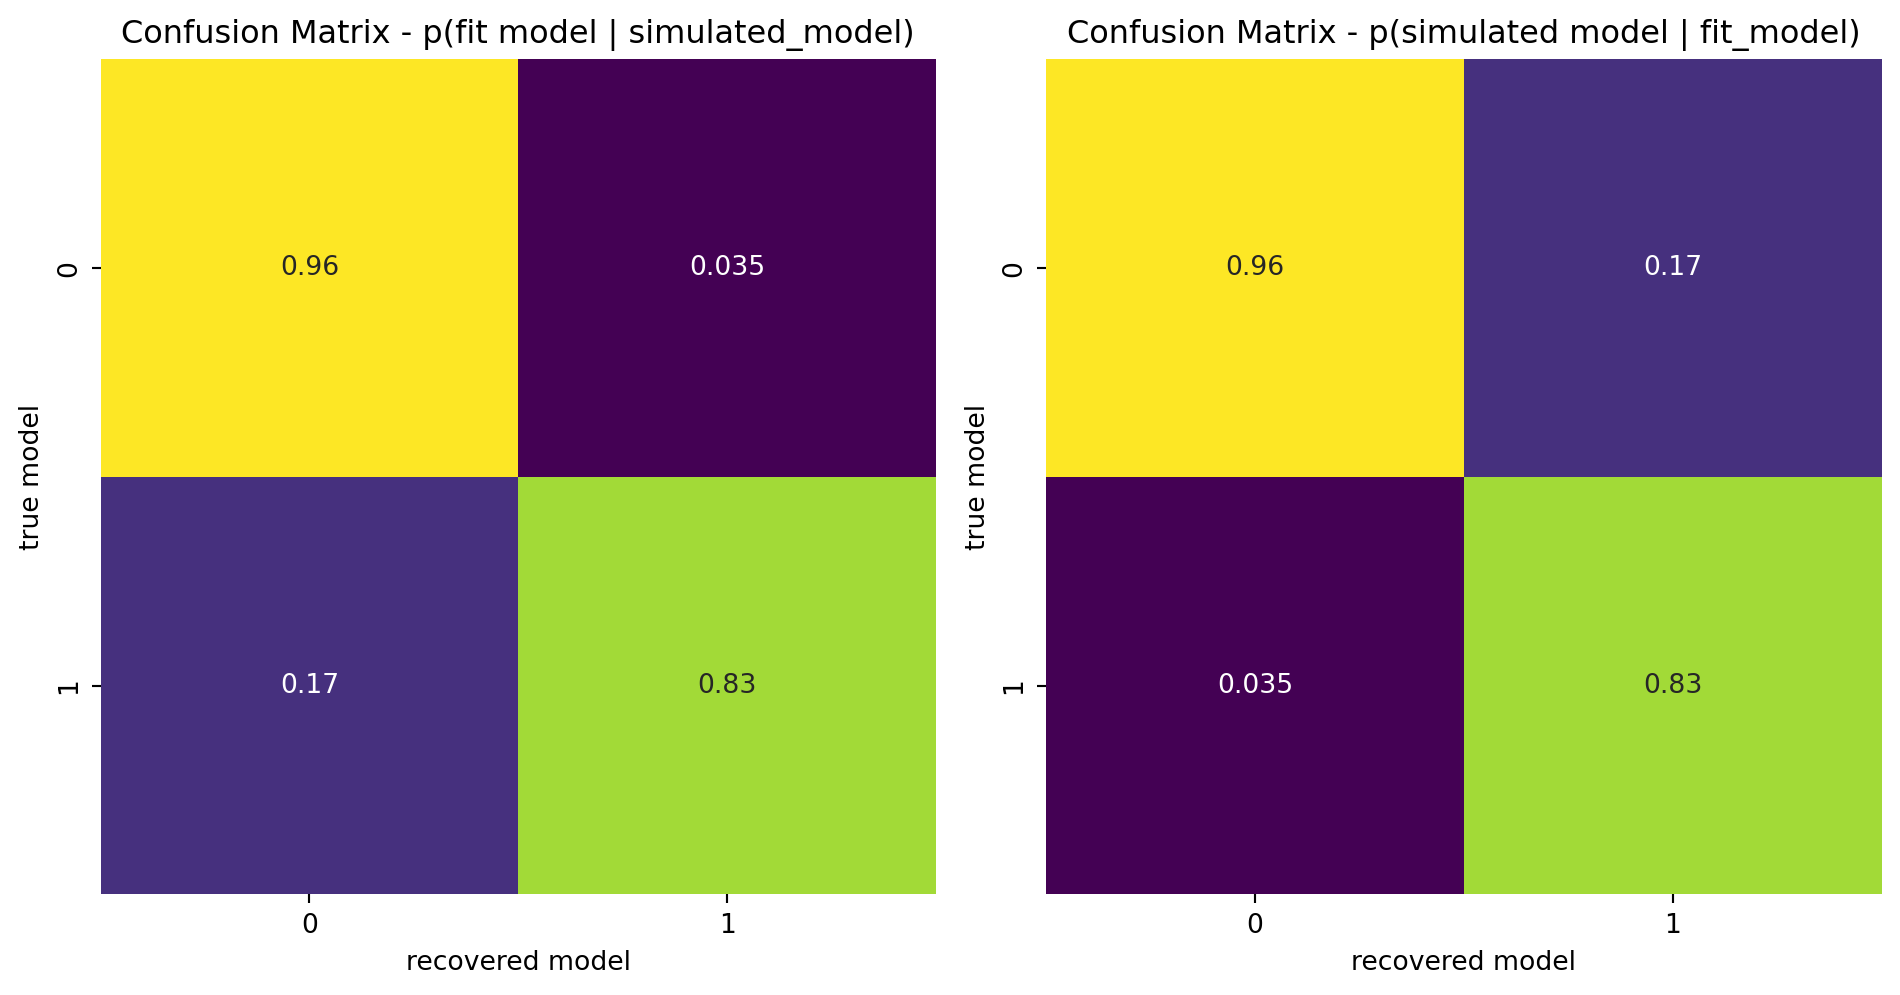

In [14]:
confusion_matrix_norm =  confusion_matrix / confusion_matrix.sum(axis=1, keepdims=True)
inversion = confusion_matrix_norm.T
inversion_matrix = inversion / inversion.sum(axis=0, keepdims=True)
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

sns.heatmap(confusion_matrix_norm, square=True, annot=True, cbar=False,
cmap="viridis", ax=axes[0])

sns.heatmap(inversion_matrix, square=True, annot=True, cbar=False,
cmap="viridis",  ax=axes[1])

axes[0].set(title="Confusion Matrix - p(fit model | simulated_model)",
ylabel="true model", xlabel="recovered model")
axes[1].set(title="Confusion Matrix - p(simulated model | fit_model)",
ylabel="true model", xlabel="recovered model")
plt.tight_layout()

## Two parameters? {.scrollable}



model {
  # Hyperpriors for Beta parameters
  alpha ~ dgamma(1.0, 1.0)  # Exponential with rate 1.0
  beta  ~ dgamma(1.0, 1.0)

  # Prior for theta with learned alpha/beta
  theta ~ dbeta(alpha, beta) T(0.001,0.999)

  # Likelihood
  k ~ dbin(theta, n)
}


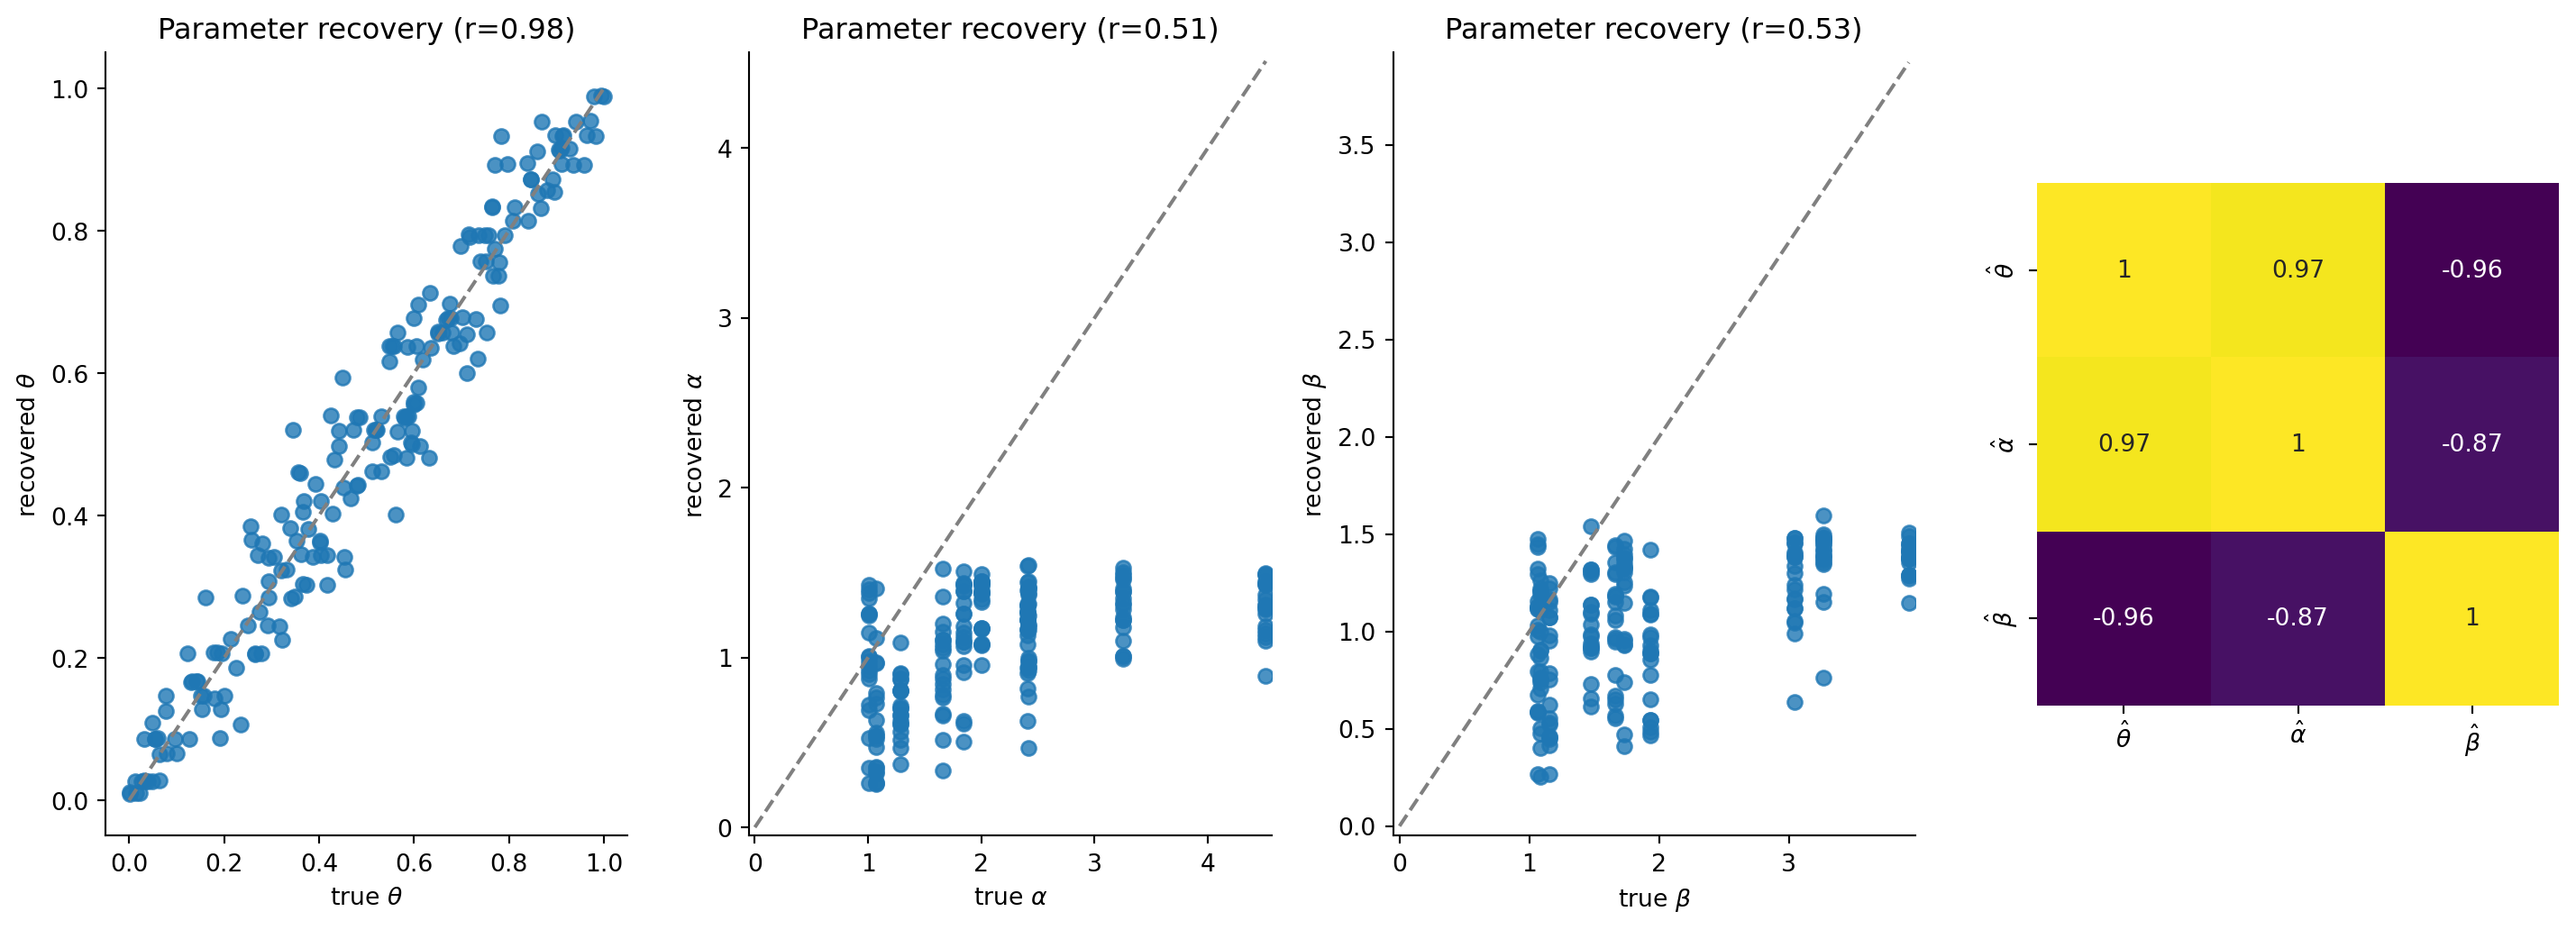

In [15]:
#| echo: true
rate_model_hier = '''
model {
  # Hyperpriors for Beta parameters
  alpha ~ dgamma(1.0, 1.0)  # Exponential with rate 1.0
  beta  ~ dgamma(1.0, 1.0)

  # Prior for theta with learned alpha/beta
  theta ~ dbeta(alpha, beta) T(0.001,0.999)

  # Likelihood
  k ~ dbin(theta, n)
}'''

print(rate_model_hier)

alpha_true = stats.gamma(1.0, 1.0).rvs(10)
beta_true = stats.gamma(1.0, 1.0).rvs(10)
n_experiments = 20

def run_simulation(alpha, beta, n_trials, jags_model, n_experiments=n_experiments):
    """
    This function is also used for simulating data in the functions below.
    """

    mean_estimates_a = np.zeros(n_experiments)
    mean_estimates_b = np.zeros(n_experiments)
    mean_estimates_c = np.zeros(n_experiments)
    thetas_true = np.zeros(n_experiments)
    datasets = np.zeros(n_experiments)
    for c in range(n_experiments):
        theta_tmp = stats.beta(alpha, beta).rvs()
        counts = stats.binom(n_trials, theta_tmp).rvs()
        data = {'k': counts, 'n': n_trials}

        model = pyjags.Model(code=jags_model, data=data, chains=2, adapt=500, progress_bar=False)
        samples = model.sample(1500, vars=['alpha', 'beta', 'theta'])

        # Get mean estimates per chain
        mean_estimates_a[c] = np.mean(samples['alpha'].ravel())
        mean_estimates_b[c] = np.mean(samples['beta'].ravel())
        mean_estimates_c[c] = np.mean(samples['theta'].ravel())
        thetas_true[c] = theta_tmp

        datasets[c] = counts

    return mean_estimates_a, mean_estimates_b, mean_estimates_c, thetas_true, datasets


alpha_pred = []
beta_pred = []
theta_pred = []
thetas_true = []

for at, bt in zip(alpha_true, beta_true):
    mean_estimates_a, mean_estimates_b, mean_estimates_c, theta_trues, _ = run_simulation(at, bt, n_trials=50, jags_model=rate_model_hier)
    alpha_pred.append(mean_estimates_a)
    beta_pred.append(mean_estimates_b)
    theta_pred.append(mean_estimates_c)
    thetas_true.append(theta_trues)

beta_pred = np.array(beta_pred).ravel()
alpha_pred = np.array(alpha_pred).ravel()
theta_pred = np.array(theta_pred).ravel()
theta_true = np.array(thetas_true).ravel()

alpha_true = np.repeat(alpha_true, n_experiments)
beta_true = np.repeat(beta_true, n_experiments)

fig, axes = plt.subplots(1, 4, figsize=(15, 5.5))

sns.regplot(y=theta_pred, x=theta_true, ax=axes[0], fit_reg=False)
axes[0].plot([0, 1], [0, 1], linestyle='--', color='gray')
axes[0].set(title=f"Parameter recovery (r={stats.pearsonr(theta_pred, theta_true)[0]:4.2f})",
      ylabel=r'recovered $\theta$', xlabel=r'true $\theta$', xlim=[-0.05,1.05], ylim=[-0.05,1.05])

alpha_max = np.max([alpha_pred.max(), alpha_true.max()])
sns.regplot(y=alpha_pred, x=alpha_true, ax=axes[1], fit_reg=False)
axes[1].plot([0, alpha_max], [0, alpha_max], linestyle='--', color='gray')
axes[1].set(title=f"Parameter recovery (r={stats.pearsonr(alpha_pred, alpha_true)[0]:4.2f})",
ylabel=r'recovered $\alpha$', xlabel=r'true $\alpha$', xlim=[-0.05 , alpha_max + 0.05], ylim=[-0.05,alpha_max + 0.05])

beta_max = np.max([beta_pred.max(), beta_true.max()])
sns.regplot(y=beta_pred, x=beta_true, ax=axes[2], fit_reg=False)
axes[2].plot([0, beta_max], [0, beta_max], linestyle='--', color='gray')
axes[2].set(title=f"Parameter recovery (r={stats.pearsonr(beta_pred, beta_true)[0]:4.2f})",
ylabel=r'recovered $\beta$', xlabel=r'true $\beta$', xlim=[-0.05 , beta_max + 0.05], ylim=[-0.05,beta_max + 0.05])

sns.heatmap(np.corrcoef(np.stack([theta_pred, alpha_pred, beta_pred])),
ax=axes[3], square=True, xticklabels=[r'$\hat{\theta}$', r'$\hat{\alpha}$', r'$\hat{\beta}$'],
yticklabels=[r'$\hat{\theta}$', r'$\hat{\alpha}$', r'$\hat{\beta}$'], annot=True, cmap='viridis',
cbar=False)

plt.tight_layout()

## Beta distributions


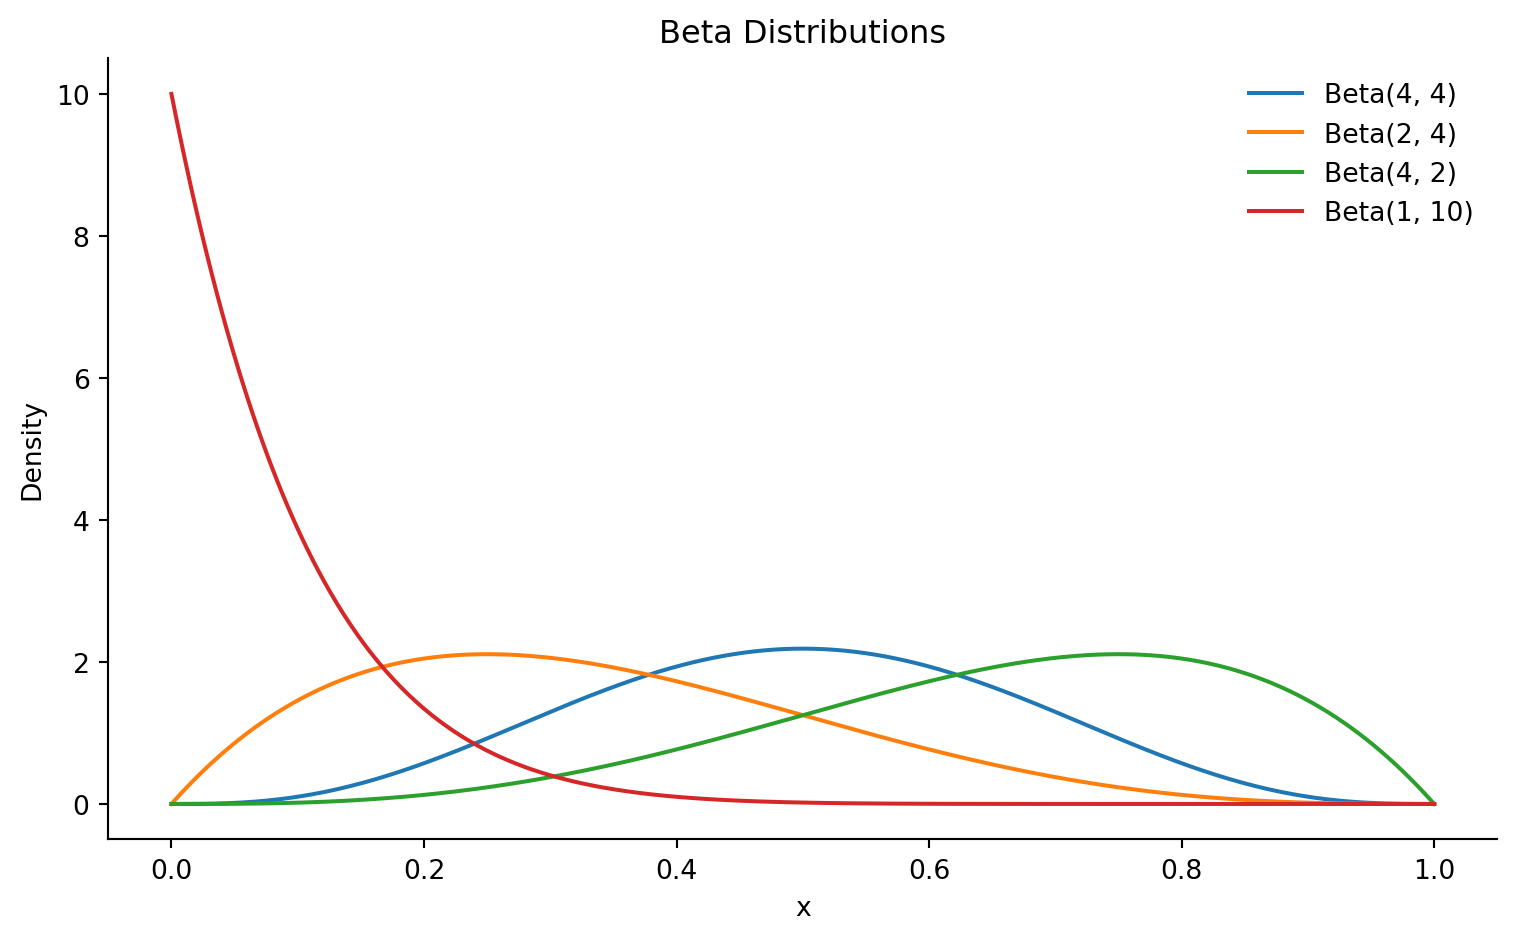

In [16]:
x = np.linspace(0, 1, 500)

# Define the beta distributions
params = {
    "Beta(4, 4)": (4, 4),
    "Beta(2, 4)": (2, 4),
    "Beta(4, 2)": (4, 2),
    "Beta(1, 10)": (1, 10),
}

# Plot each distribution
fig, axes = plt.subplots(figsize=(8, 5))
for label, (a, b) in params.items():
    plt.plot(x, stats.beta.pdf(x, a, b), label=label)

# Style the plot
axes.set(title="Beta Distributions", xlabel="x", ylabel="Density")
axes.legend(fancybox=False, framealpha=0.0)
plt.tight_layout()